# TM10007 Assignment Group 5

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/annawalstra/tm10007_Group5.git
!pip install simpleITK

     |████████████████████████████████| 42.5MB 106kB/s 


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The number of spamples: 855
The number of columns: 268


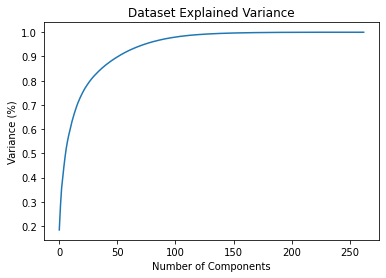

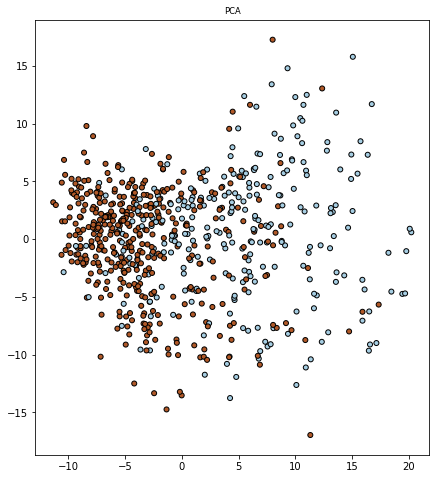

In [2]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets as ds
import seaborn


# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition
# Too learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

# Data loading functions. Uncomment the one you want to use
from adni.load_data import load_data
data = load_data()
print(f'The number of spamples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Creating X and Y 
X = data.loc[:, data.columns != 'label']
Y = data['label']

# Preprocessing: deleting features with only zeros
X = X.loc[:, (X != 0).any(axis=0)]
# print(f'The number of spamples: {len(X.index)}')
# print(f'The number of columns: {len(X.columns)}')

# Binarize Y labels
y_bin = preprocessing.label_binarize(Y, ['CN','AD'])
y_bin = [i[0] for i in y_bin]
#print(y_bin)

# Split the dataset in train and test part
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, y_bin, test_size=0.2, stratify=y_bin)


# Scale the data 
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Fitting the PCA algorithm with our Data
from sklearn.decomposition import PCA

pca = PCA().fit(X_train_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Dataset Explained Variance')
plt.show()


# Perform a PCA
pca = decomposition.PCA(n_components=50)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# # Use the selectfrommodel module: L1 Select all features with a weight above the median.
# from sklearn.feature_selection import SelectFromModel
# from sklearn.linear_model import Lasso, RidgeClassifier
# selector = SelectFromModel(estimator=Lasso(alpha=10**(-5)), threshold='median')
# selector.fit(X_train_scaled, Y_train)
# n_original = X_train_scaled.shape[1]
# X_train_L1 = selector.transform(X_train_scaled)
# X_test_L1 = selector.transform(X_test_scaled)
# n_selected = X_train_L1.shape[1]
# print(f"Selected {n_selected} from {n_original} features.")

#Plot first feature PCA
fig = plt.figure(figsize=(24,8))
ax = fig.add_subplot(131)
ax.set_title("PCA", fontsize='small')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=Y_train,
            s=25, edgecolor='k', cmap=plt.cm.Paired)


# #Plot first feature L1 selection
# fig = plt.figure(figsize=(24,8))
# ax = fig.add_subplot(132)
# ax.set_title("L1", fontsize='small')
# ax.scatter(X_train_L1[:, 0], X_train_L1[:, 1], marker='o', c=Y_train,
#             s=25, edgecolor='k', cmap=plt.cm.Paired)


# Crossvalidation for parameter tuning
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

## KNN Classifier

Vraag: met grid_search.best_estimator_ krijg ik als het beste resultaat k=33, maar als ik k=25 invul krijg ik een hoger resultaat voor test en train. 

vgm snap ik dit nu wel...Soms grid_search.best_estimator_ ander resultaat voor beste k dan clf.n_neigbors


In [7]:
# # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
# # Specify the classifier
# knn = neighbors.KNeighborsClassifier()
# parameters = {"n_neighbors": list(range(1, 51, 2))}
# cv_10fold = model_selection.StratifiedKFold(n_splits=10)
# grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='accuracy')
# grid_search.fit(X_train_pca, Y_train)
# # Show the complete results of the cross validation
# display(pd.DataFrame(grid_search.cv_results_))


# # # Fit kNN
# # Get resulting classifier
# print(grid_search.best_estimator_)
# #print(f'Best classifier: k={clf.n_neighbors}')
# clf = neighbors.KNeighborsClassifier(n_neighbors=21)
# clf.fit(X_train_pca, Y_train)
# score_train = clf.score(X_train_pca, Y_train)
# score_test = clf.score(X_test_pca, Y_test)

# # Get the accuracy
# y_pred = clf.predict(X_train_pca)
# acc_train=metrics.accuracy_score(Y_train, y_pred)
# y_pred = clf.predict(X_test_pca)
# acc_test=metrics.accuracy_score(Y_test, y_pred)

# # Print result
# print(f"Training result: {score_train}")
# print(f"Test result: {score_test}")
# print(f"Accuracy:")
# print(f"Training result: {acc_train}")
# print(f"Test result: {acc_test}")


#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,50))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors,leaf_size=leaf_size, p=p)
#Create new KNN object
knn_2 = neighbors.KNeighborsClassifier()
#Use GridSearch
#cv_10fold = model_selection.StratifiedKFold(n_splits=10)
random_search = model_selection.RandomizedSearchCV(knn_2, hyperparameters, cv=cv_10fold)

#Fit the model
best_model = random_search.fit(X_train_pca,Y_train)
clf = random_search.best_estimator_

#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])
print(clf)

# Test train
from sklearn.metrics import classification_report
y_pred_train = clf.predict(X_train_pca)
print(classification_report(Y_train, y_pred_train))
# Test model

y_pred = clf.predict(X_test_pca)
print(classification_report(Y_test, y_pred))

Best leaf_size: 21
Best p: 2
Best n_neighbors: 15
KNeighborsClassifier(algorithm='auto', leaf_size=21, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       269
           1       0.82      0.92      0.87       415

    accuracy                           0.83       684
   macro avg       0.83      0.80      0.81       684
weighted avg       0.83      0.83      0.82       684

              precision    recall  f1-score   support

           0       0.75      0.60      0.67        67
           1       0.77      0.88      0.82       104

    accuracy                           0.77       171
   macro avg       0.76      0.74      0.74       171
weighted avg       0.76      0.77      0.76       171



## KNN with Crossvalidation


Best classifier: k=17
Best classifier: k=17
Best classifier: k=17
Best classifier: k=17
Best classifier: k=15
Best classifier: k=15
Best classifier: k=15
Best classifier: k=15
Best classifier: k=15
Best classifier: k=15
Best classifier: k=15
Best classifier: k=15
Best classifier: k=13
Best classifier: k=15
Best classifier: k=19
Best classifier: k=15
Best classifier: k=15
Best classifier: k=19
Best classifier: k=19
Best classifier: k=17


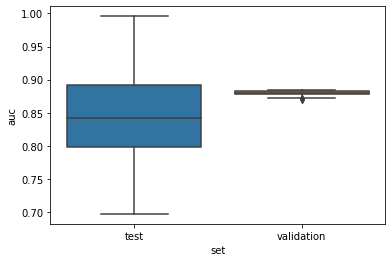

The optimal N=15
0.7920560747663551


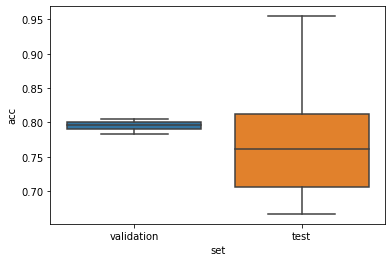

In [0]:
# Create a 20 fold stratified CV iterator
cv_20fold = model_selection.StratifiedKFold(n_splits=20)
results = []
results_acc = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(X_train_pca, Y_train):
    # Split the data properly
    X_validation = X_train_pca[validation_index]
    y_validation = np.array(Y_train)[validation_index]
    
    X_testKNN = X_train_pca[test_index]
    y_testKNN = np.array(Y_train)[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = neighbors.KNeighborsClassifier()
    cv_10fold = model_selection.StratifiedKFold(n_splits=10)
    grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_testKNN)
    scores = probabilities[:, 1]

    # Get the accuracy
    y_pred = clf.predict(X_validation)
    accuracy=metrics.accuracy_score(y_validation, y_pred)
    results_acc.append({'acc': accuracy,'set': 'validation'})
    y_pred = clf.predict(X_testKNN)
    accuracy = metrics.accuracy_score(y_testKNN, y_pred)
    results_acc.append({'acc': accuracy,'set': 'test'})
    
    # Get the auc
    auc = metrics.roc_auc_score(y_testKNN, scores)
    results.append({'auc': auc,'k': clf.n_neighbors,'set': 'test'})
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
plt.show()
seaborn.boxplot(y='auc', x='set', data=results)
plt.show()
results_acc = pd.DataFrame(results_acc)
seaborn.boxplot(y='acc', x='set', data=results_acc)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")

from sklearn.metrics import classification_report

print(classification_report(Y_test, clf.predict(X_test_pca)))
#y_pred = clf.predict(X_test_pca)
print(clf.score(X_test_pca, Y_test))

# Support Vector Machine (SVM) Classifier 



In [0]:
# Construct classifiers and corresponding kernel (comment the ones that we do not want to use)

# Linear kernel:
svmlin = SVC(kernel='linear', gamma='scale')
# Radial Basis Function (RBF) kernel:
svmrbf = SVC(kernel='rbf', gamma='scale')
# Polynomial kernel:
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

# Other options on kernels:
# - change gamma
# - sampler, for example: first use RBF sampler, then linear kernel
# - manually constructed kernel function?
# - precomputed kernel
# - sigmoid kernel

# Possibility: start with linear kernel and then gradually increase complexity
clsfs = [svmlin, svmrbf, svmpoly]

# Create lists of datasets to loop over (klopt dit?)

Xs = X_train_pca
Ys = Y_train

# Important hyperparameters in SVM:
# - degree of the kernel
# - coef0s
# - slacks

# Tune hyperparameters (for now just a couple of examples)
degrees = [1, 3, 5] # degree of the kernel (d) 
coef0s = [0.01, 0.5, 1] # the homogeneity of the kernel (c)
slacks = [0.01, 0.5, 1] # slack parameter (C)
    
clsfs = list() 
for degree in degrees:
    for coef0 in coef0s:
        for slack in slacks:
            clsfs.append(SVC(kernel='linear', degree=degree, coef0=coef0, C=slack, gamma='scale'))


# Now use the classifier on all data
for clsf in clsfs:
  clsf.fit(Xs, Ys)
  y_pred = clsf.predict(Xs)
  print(f"kernel: {clsf.kernel}")
  print(f"degree: {clsf.degree}, coef0: {clsf.coef0}, C: {clsf.C}. ")
  print("Misclassified: %d / %d" % ((Ys != y_pred).sum(), Xs.shape[0]))
  #ax = fig.add_subplot(clsf + 1, 3, num + 1)
  #ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
             #s=25, edgecolor='k', cmap=plt.cm.Paired)
  #colorplot(clsf, ax, X[:, 0], X[:, 1]) 
  #ax.set_title(t)
  #num += 1



kernel: linear
degree: 1, coef0: 0.01, C: 0.01. 
Misclassified: 68 / 427
kernel: linear
degree: 1, coef0: 0.01, C: 0.5. 
Misclassified: 57 / 427
kernel: linear
degree: 1, coef0: 0.01, C: 1. 
Misclassified: 57 / 427
kernel: linear
degree: 1, coef0: 0.5, C: 0.01. 
Misclassified: 68 / 427
kernel: linear
degree: 1, coef0: 0.5, C: 0.5. 
Misclassified: 57 / 427
kernel: linear
degree: 1, coef0: 0.5, C: 1. 
Misclassified: 57 / 427
kernel: linear
degree: 1, coef0: 1, C: 0.01. 
Misclassified: 68 / 427
kernel: linear
degree: 1, coef0: 1, C: 0.5. 
Misclassified: 57 / 427
kernel: linear
degree: 1, coef0: 1, C: 1. 
Misclassified: 57 / 427
kernel: linear
degree: 3, coef0: 0.01, C: 0.01. 
Misclassified: 68 / 427
kernel: linear
degree: 3, coef0: 0.01, C: 0.5. 
Misclassified: 57 / 427
kernel: linear
degree: 3, coef0: 0.01, C: 1. 
Misclassified: 57 / 427
kernel: linear
degree: 3, coef0: 0.5, C: 0.01. 
Misclassified: 68 / 427
kernel: linear
degree: 3, coef0: 0.5, C: 0.5. 
Misclassified: 57 / 427
kernel: l

**Random Forrest Classifier**

The Random Forrest Classifier has 19 different hyperparameters:
- n_estimators: number of trees (to much --> overfitting)
- criterion: How to measure the quality of a split (gini) (tree-specific)
- max_depth: depth of the tree
- min_samples_split: minimum number of samples required to split an internal node
- min_samples_leaf: number of samples required to be at a node
- min_weight_fraction_leaf: sum total of the weigths at a node.
- max_features: number of features to consider
- max_leaf_nodes: 
- min_impurity_decrease: node will split if impurity decreases with this value
- min_impurity_split: A node will split if its impurity is above the threshold, otherwise it is a leaf
- bootstrap: use or not (T/F) (To improve accuracy by creating samples)
if T --> max_samples: number of samples to train each base estimator
- oob_score: use out-of-bag samples
- n_jobs: 
- random_state: 
- verbose:
- warm_start:
- class_weight: If one class is more important
- ccp_alpha: x

--> Misschien toevoegen: een tijd segment om te kijken of het niet te lang duurt




In [0]:
#Hyperparameters tuning:
n_tree = [10,25,50,100]  # n_estimators
boot = ['True','False']  # Bootstrapping
criterion = ['gini','entropy'] # measure of quality
max_depth = [range(5, 16)] # Depth of the tree
min_samples_split = [range(2,7)] # prevends overfitting
min_samples_leaf = [1,2] # prevends overfitting
classweight = [{0: 1, 1: 0.001},{0: 1, 1: 1},
               {0: 1, 1: 10},{0: 1, 1: 100}]


clsfs = [n_tree, boot, criterion, max_depth, min_samples_split, 
         min_samples_leaf, classweight]


# Y_test = validation set, niet de test set
for clf in clsfs:
  for hype_par in clf:
    for X, Y in zip(Xtrain,Ytrain):
      clf.fit(X, Y)
      y_pred_train = clf.predict(X_train_pca)
      acc_train = metrics.accuracy_score(Y_train, y_pred)
      y_pred_test = clf.predict(X_test_pca)
      acc_test = metrics.accuracy_score(Y_test, y_pred)
      acc_test_clsfs.append(acc_test)
    maxpos = acc.index(max(acc_test_clsfs))
  # hier moet nog dat het die plek van deze classifier is 

clsfs_final = [RandomForestClassifier(n_estimators = n_tree(n_tree[maxpos]))]

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
for X, Y in zip(Xs, Ys):
    ax = fig.add_subplot(7, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    num += 1
    
# Now use the classifiers on all datasets
for clf in clsfs:
    for X, Y in zip(Xs, Ys):
        clf.fit(X, Y)
        ax = fig.add_subplot(7, 3, num + 1)
        ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
        colorplot(clf, ax, X[:, 0], X[:, 1])
        y_pred = clf.predict(X)
        t = ("Misclassified: %d / %d" % ((Y != y_pred).sum(), X.shape[0]))
        ax.set_title(t)
        num += 1

False
